# Afterpulse Detection (dead-time / internal reflections)
To figure out how to detect and remove afterpulses, and plot examples.
- use photon rate just around the lake surface elevation (depending on strong/weak beam??)
- then use peaks distances that are commonly found

### From the literature
afterpulses at: ∼0.45, ∼0.9, ∼2.3, and ∼4.2 m

The afterpulses captured from on-orbit measurements are caused by three different reasons: (1) the effects of the dead-time circuit (∼3 ns) due to PMT saturation; (2) the effects of optical reflections within the ATLAS receiver optical components; (3) PMT afterpulses. The echoes separated by ∼0.45 m are attributed to the effect of the dead-time circuit (∼3 ns) due to PMT saturation. The echoes at ∼2.3 and ∼4.2 m below the primary surface returns are caused by the optical reflections within the ATLAS receiver optical components, while the echoes from ∼10 to ∼45 m away from the primary surface signal are due to the PMT afterpulses with a longer time delay.

Lu, X., Hu, Y., Yang, Y., Vaughan, M., Palm, S., Trepte, C., ... & Baize, R. (2021). Enabling value added scientific applications of ICESat‐2 data with effective removal of afterpulses. Earth and Space Science, 8(6), e2021EA001729.

In [2]:
%matplotlib widget
import os
import h5py
import pickle
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime
import time
from IPython.display import Image, display
from cmcrameri import cm as cmc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.neighbors import KernelDensity
from scipy.signal import find_peaks
# import hdbscan
plt.rcParams.update({'font.size': 8})

In [3]:
def convert_time_to_string(dt):
    epoch = dt + datetime.datetime.timestamp(datetime.datetime(2018,1,1))
    return datetime.datetime.fromtimestamp(epoch).strftime("%Y-%m-%d, %H:%M:%S")

def read_melt_lake_h5(fn):
    
    lakedict = {}
    with h5py.File(fn, 'r') as f:

        # metadata
        for key in f['properties'].keys(): 
            lakedict[key] = f['properties'][key][()]
            if f['properties'][key].dtype == object:
                lakedict[key] = lakedict[key].decode('utf-8')
                

        # photon data
        photon_data_dict = {}
        for key in f['photon_data'].keys():
            photon_data_dict[key] = f['photon_data'][key][()]
        lakedict['photon_data'] = pd.DataFrame(photon_data_dict)

        # mframe data
        mframe_data_dict = {}
        for key in f['mframe_data'].keys():
            mframe_data_dict[key] = f['mframe_data'][key][()]
        lakedict['mframe_data'] = pd.DataFrame(mframe_data_dict).set_index('mframe')    

        # second returns data
        det_2nds_dict = {}
        for key in f['detection_2nd_returns'].keys():
            det_2nds_dict[key] = f['detection_2nd_returns'][key][()]
        lakedict['detection_2nd_returns'] = det_2nds_dict

        # quality assessment data
        qual_dict = {}
        for key in f['detection_quality_info'].keys():
            qual_dict[key] = f['detection_quality_info'][key][()]
        lakedict['detection_quality_info'] = qual_dict
        
        # re-nest the lake extent segments
        def re_nest_extent(x): return [[x[i], x[i+1]] for i in np.arange(0,len(x),2)]
        lakedict['surface_extent_detection'] = re_nest_extent(lakedict['surface_extent_detection'])
        lakedict['lat_surface_extent_detection'] = re_nest_extent(lakedict['lat_surface_extent_detection'])
        
        lakedict['date_time'] = convert_time_to_string(lakedict['mframe_data']['dt'].mean())
        
        return lakedict

In [4]:
searchfor = 'lake_'
searchdir = 'WAIS_region_comps/'
filelist = [searchdir+f for f in os.listdir(searchdir) \
            if os.path.isfile(os.path.join(searchdir, f)) & (searchfor in f) & ('.h5' in f)]

searchfor = 'lake_'
searchdir = 'WAIS_2018-22-meltregions/'
filelist += [searchdir+f for f in os.listdir(searchdir) \
            if os.path.isfile(os.path.join(searchdir, f)) & (searchfor in f) & ('.h5' in f) & ('george' not in f)]

print('There are %i files.' % len(filelist))

There are 2940 files.


In [7]:
# thresh_upper = 1.005
# thresh_lower = -7.505
# bin_h = 0.01
# smooth_h = 0.1
saturation_threshold = 1.0

cols_pk = ['black','#CD104D', '#E14D2A', '#FD841F', '#999400', '#8FE3CF', '#256D85']
lsty_pk = ['-', '-', '--', '-.', ':', '--', '--']
peak_target_elevs = [0.0, -0.56, -0.93, -1.47, -1.85, -2.44, -4.25]
widths_pk = [0.225, 0.225, 0.225, 0.225, 0.225, 0.3, 0.3] # 0.225 m on each side makes it 0.45 total, which is the dead-time for ATLAS
df_pks_info = pd.DataFrame({'target': peak_target_elevs, 'width': widths_pk, 'color': cols_pk, 'ls': lsty_pk})

# new function for estimating ratio saturated and saturated peak better
def get_saturation_and_elevation(hvals, num_channels, dead_time):
    speed_of_light = 299792458 #m/s
    hvals = np.flip(np.sort(np.array(hvals).flatten()))
    if len(hvals) < num_channels:
        return pd.Series({'elev_saturation': np.nan, 'ratio_saturation': 0.0})
    else:
        diffs = np.abs(hvals[num_channels-1:] - hvals[:-num_channels+1])
        diff_threshold_saturated = dead_time * speed_of_light / 2.0
        diff_means_saturated = diffs <= diff_threshold_saturated
        if np.sum(diff_means_saturated) > 1:
            first_saturated_idx = next(i for i,val in enumerate(diffs) if val <= diff_threshold_saturated*1.01)
            first_saturated_elev = hvals[first_saturated_idx+num_channels-1]
            hvals = hvals[hvals > (first_saturated_elev - diff_threshold_saturated/2)]
            diffs = np.abs(hvals[num_channels-1:] - hvals[:-num_channels+1])
        start_saturated = np.argmin(diffs)
        end_saturated = start_saturated+num_channels
        hvals_saturated = hvals[start_saturated:end_saturated]
        elev_saturated = np.median(hvals_saturated)
        # ratio_saturated = diff_threshold_saturated / (np.max(hvals_saturated)-np.min(hvals_saturated))
        ratio_saturated = diff_threshold_saturated / (4*np.std(hvals_saturated))
        return pd.Series({'elev_saturation': elev_saturated, 'ratio_saturation': ratio_saturated})
    
def to_hhmmss(secs): 
    h = np.floor(secs/(60*60))
    secs = secs-h*60*60
    m = np.floor(secs/60)
    s = secs - m*60
    return '%02i:%02i:%02i' % (h,m,s)

In [6]:
# filelist = filelist[:100]
df_list = []
perc_sat_list = []
max_sat_list = []
n_lakes = 0
min_sat_vals_for_max = 100

start = time.time()
for i,filename in enumerate(filelist):
    
    lk = read_melt_lake_h5(filename)
    df = lk['photon_data']
    surf_elev = lk['surface_elevation']
    beam_strength = lk['beam_strength']
    deadtime = lk['dead_time']
    n_channels = 4 if beam_strength == 'weak' else 16
    df['pulseid'] = 1000*df.mframe.astype(np.uint64)+df.ph_id_pulse.astype(np.uint64)
    df['ph_index'] = df.index
    df = df.set_index('pulseid')
    thegroup = df.groupby('pulseid')
    df_grouped = thegroup[['xatc', 'lat', 'lon']].mean()
    kwargs = {'num_channels': n_channels, 'dead_time': deadtime}
    saturation_fraction_and_elevation = thegroup[['h']].apply(get_saturation_and_elevation, **kwargs)
    df_grouped = pd.concat([df_grouped, saturation_fraction_and_elevation], axis=1)
    df_grouped['is_saturated'] = df_grouped.ratio_saturation >= saturation_threshold
    df_join = df.join(df_grouped[['ratio_saturation', 'elev_saturation', 'is_saturated']], on='pulseid', how='left')
    df_join['h_relative_to_saturated_peak'] = df_join.h - df_join.elev_saturation
    df_join['beam_strength'] = beam_strength
    df_join['beam_number'] = lk['beam_number']
    df_join['gtx'] = lk['gtx']
    df_join['lake_nr'] = i
    
    perc_sat_list.append(np.sum(df_grouped.is_saturated) / len(df_grouped))
    
    saturation_list = np.sort(df_grouped.ratio_saturation[~np.isnan(df_grouped.ratio_saturation)])
    if len(saturation_list) >= min_sat_vals_for_max:
        max_sat_list.append(np.median(saturation_list[-min_sat_vals_for_max:]))
    
    df_list.append(df_join)
    
    elapsed = time.time() - start
    remaining = elapsed / (i+1) * (len(filelist)-i-1)
    print('reading in lake files: %4i / %4i   (elapsed: %s, remaining %s)' %\
          (i+1, len(filelist), to_hhmmss(elapsed), to_hhmmss(remaining)), end='\r')
    
dfs_all = pd.concat(df_list)
del df_list
print('\n---> done!')

reading in lake files: 2940 / 2940   (elapsed: 00:32:00, remaining 00:00:00)
---> done!


In [7]:
# dfs_all.to_pickle("dfs_all.pkl")

In [8]:
dfs_all = pd.read_pickle("dfs_all.pkl")

In [9]:
beam_select = 'strong'
if type(beam_select) == int:
    dfs = dfs_all[dfs_all.beam_number == beam_select]
    thisstrength = 'strong' if beam_select%2==1 else 'weak'
    beam_select_str = '#%i, %s' % (beam_select, thisstrength)
elif beam_select == 'strong':
    dfs = dfs_all[dfs_all.beam_strength == 'strong']
elif beam_select == 'weak':
    dfs = dfs_all[dfs_all.beam_strength == 'weak']
elif 'gt' in beam_select:
    dfs = dfs_all[dfs_all.gtx == beam_select]
elif beam_select == 'all':
    dfs = dfs_all
else:
    dfs = dfs_all[dfs_all.beam_strength == beam_select]
n_lakes = len(np.unique(dfs.lake_nr))

In [39]:
select_beam = -1
sort_by = 'percent_saturated'
# sort_by = 'max_ratio_saturated'

perc_sat = dfs_all.groupby('lake_nr')['is_saturated'].mean()
beamnr = dfs_all.groupby('lake_nr')['beam_number'].first()
beamstr = dfs_all.groupby('lake_nr')['beam_strength'].first()
gtx_lake = dfs_all.groupby('lake_nr')['beam_strength'].first()
df_perc_sat = pd.DataFrame({'percent_saturated': perc_sat_list, 'max_ratio_saturated': max_sat_list, 
                            'gtx': gtx_lake, 'beam_number': beamnr, 'beam_strength': beamstr, 'file': filelist})
groupbeams = df_perc_sat.groupby('beam_number')
summarydf = pd.DataFrame([groupbeams['beam_strength'].first(),
              groupbeams['percent_saturated'].mean(),
              groupbeams['max_ratio_saturated'].apply(np.percentile,**{'q': 95})])

if select_beam > 0: df_perc_sat = df_perc_sat[df_perc_sat.beam_nr==select_beam]
df_perc_sat.sort_values(by='percent_saturated', inplace=True, ascending=False)
for i in range(10):
    row = df_perc_sat.iloc[i]
    print('# %.2f%% saturated, max ratio saturated: %.1f, beam %i (%s)'%\
          (row.percent_saturated, row.max_ratio_saturated, row.beam_number, row.beam_strength))
    print('#fn = \'%s\'' % df_perc_sat.iloc[i].file)
    
summarydf

# 0.90% saturated, max ratio saturated: 22.0, beam 6 (weak)
#fn = 'WAIS_region_comps/lake_09974_AIS_2018-19_amery_ATL03_20190102184312_00810210_005_01_gt3r.h5'
# 0.88% saturated, max ratio saturated: 10.4, beam 4 (weak)
#fn = 'WAIS_region_comps/lake_10000_GrIS_2019_west_greenland_ATL03_20190625062608_13440303_005_01_gt2r.h5'
# 0.78% saturated, max ratio saturated: 27.7, beam 4 (weak)
#fn = 'WAIS_region_comps/lake_09875_GrIS_2019_west_greenland_ATL03_20190617064249_12220303_005_01_gt2r.h5'
# 0.71% saturated, max ratio saturated: 20.1, beam 2 (weak)
#fn = 'WAIS_2018-22-meltregions/lake_10000_AIS_2020-21_waismeltregions_wilkins_ATL03_20210123161143_04681010_005_01_gt3l.h5'
# 0.69% saturated, max ratio saturated: 10.0, beam 3 (strong)
#fn = 'WAIS_2018-22-meltregions/lake_09865_AIS_2021-22_waismeltregions_larsen_ATL03_20220116110420_03841412_005_01_gt2l.h5'
# 0.65% saturated, max ratio saturated: 53.2, beam 4 (weak)
#fn = 'WAIS_2018-22-meltregions/lake_09978_AIS_2021-22_waismeltregions_lars

beam_number,1,2,3,4,5,6
beam_strength,strong,weak,strong,weak,strong,weak
percent_saturated,0.039094,0.094019,0.055447,0.132366,0.040251,0.099425
max_ratio_saturated,3.237518,10.369037,4.412662,16.564655,3.047964,10.525778


In [10]:
from PIL import Image
def make_gif(img_list, img_name='mygif.gif', duration=100):
    frames = [Image.open(image) for image in img_list]
    frame_one = frames[0]
    frame_one.save(img_name, format="GIF", append_images=frames,
               save_all=True, duration=duration, loop=0)

In [72]:
searchfor = '.jpg'
searchdir = 'animate_afterpulses/'
imglist = [searchdir+f for f in os.listdir(searchdir) \
            if os.path.isfile(os.path.join(searchdir, f)) & (searchfor in f) & ('minmax' in f)]
imglist.sort()
imgname = "animation_all_beams_minmax.gif"
make_gif(imglist, img_name=imgname, duration=500)

In [41]:
searchfor = '.jpg'
searchdir = 'animate_afterpulses/'
imglist = [searchdir+f for f in os.listdir(searchdir) \
            if os.path.isfile(os.path.join(searchdir, f)) & (searchfor in f) & ('maxlim' in f) & ('all-beams' in f)]
imglist.sort()
imgname = "animation_all_beams_maxlim.gif"
make_gif(imglist, img_name=imgname, duration=200)

In [42]:
searchfor = '.jpg'
searchdir = 'animate_afterpulses/'
imglist = [searchdir+f for f in os.listdir(searchdir) \
            if os.path.isfile(os.path.join(searchdir, f)) & (searchfor in f) & ('maxlim' in f) & ('strong-beams' in f)]
imglist.sort()
imgname = "animation_strong_beams_maxlim.gif"
make_gif(imglist, img_name=imgname, duration=200)

In [43]:
searchfor = '.jpg'
searchdir = 'animate_afterpulses/'
imglist = [searchdir+f for f in os.listdir(searchdir) \
            if os.path.isfile(os.path.join(searchdir, f)) & (searchfor in f) & ('maxlim' in f) & ('weak-beams' in f)]
imglist.sort()
imgname = "animation_weak_beams_maxlim.gif"
make_gif(imglist, img_name=imgname, duration=200)

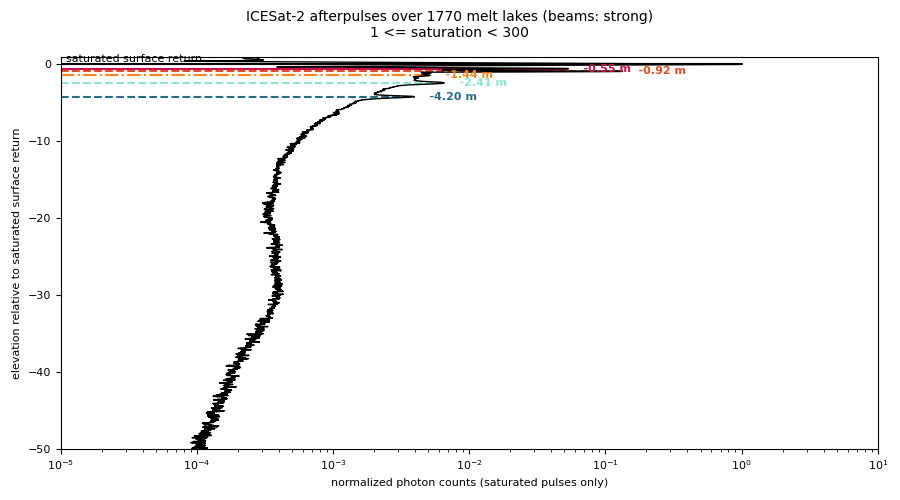

In [16]:
plt.close('all')

thresh_upper = 1.0
thresh_lower = -50
h_res = 0.001
kernel_width = 0.03

# histogram binning for afterpulse peaks vs. elevation
h_vals = np.arange(thresh_lower, thresh_upper+h_res, h_res)
bins = np.arange(start=thresh_lower, stop=thresh_upper, step=h_res)
mids = bins[:-1] + 0.5 * h_res

threshs =  np.concatenate((np.arange(0.0, 2.0, 0.25), np.arange(2.0, 5.0, 0.5), np.arange(5.0, 10.0, 1.0), 
                           np.arange(10.0, 50.0, 10.0), np.arange(50.0, 100.0, 25.0), np.arange(100.0, 301.0, 200.0)))

threshs = np.concatenate((np.arange(0.8, 10, 0.1), np.arange(10.0, 30.0, 1.0), np.arange(30.0, 231.0, 10.0)))

threshs = [300]

for ithresh, thresh in enumerate(threshs): 

    fig, ax = plt.subplots(figsize=[9, 5], dpi=100)
    sat_min = 1
    sat_max = thresh
    issat = (dfs.ratio_saturation >= sat_min) & (dfs.ratio_saturation < sat_max)

    def get_histograms(h_ph, weights, bins, kernel_width):
        std = int(np.round(kernel_width / (bins[1]-bins[0])))
        window_size = 3*std
        hist_h = np.histogram(h_ph, bins=bins, density=True, weights=weights)
        hist_h_smooth = np.array(pd.Series(hist_h[0]).rolling(window_size,center=True,min_periods=1,win_type='gaussian').mean(std=std))
        hist_h_plot = np.array(hist_h[0]) / hist_h_smooth.max()
        hist_h_smooth = hist_h_smooth / hist_h_smooth.max()
        return hist_h_plot, hist_h_smooth

    hists_issat = get_histograms(dfs.h_relative_to_saturated_peak[issat], weights=dfs.ratio_saturation[issat], bins=bins, kernel_width=kernel_width)

    dist_m = 0.1
    dens_sat = np.log10(hists_issat[1])
    hvals = mids[mids<0.2]
    dens_sat = dens_sat[mids<0.2]
    hists_issat_cut = hists_issat[1][mids<0.2]
    peaks, props = find_peaks(dens_sat, distance=np.round(dist_m/h_res), prominence=0.05)
    props['idx'] = peaks
    props['elev'] = np.round(hvals[peaks],2)
    props['height'] = hists_issat_cut[peaks]
    df_sat = pd.DataFrame(props)
    df_sat.reset_index(drop=True, inplace=True)
    df_sat.sort_values(by='prominences', ascending=False, ignore_index=True, inplace=True)
    df_pks_info['elev_actual'] = np.nan
    df_pks_info['height_peak'] = np.nan
    for i in range(len(df_pks_info)):
        thispk = df_pks_info.iloc[i]
        pk_idx = np.argmin(np.abs(df_sat.elev-thispk.target))
        if np.min(np.abs(df_sat.elev-thispk.target)) < 0.2:
            df_pks_info.at[i,'elev_actual'] = df_sat.elev[pk_idx]
            df_pks_info.at[i,'height_peak'] = df_sat.height[pk_idx]
            

    ## plot
    ylms = (thresh_lower, thresh_upper)
    xlim_ax2 = (1e-5,10)

#     # histogram showing peaks for specular returns
#     # ax.scatter(hists_nosat[0], mids, s=3, color='black', lw=0.5, edgecolors='none', alpha=0.15)
#     ax.plot(hists_nosat[1], mids, 'k-', lw=1)
#     ax.set_xlabel('normalized photon counts, non-saturated pulses')
#     ax.set_ylabel('elevation relative to surface')
#     ax.set_xlim(xlim_ax2)
#     ax.set_ylim(ylms)
#     ax.set_xscale('log')
#     elev_surfpk = mids[np.argmax(hists_nosat[1])]
#     h_peak = np.max(hists_nosat[1])
#     ax.plot([xlim_ax2[0], h_peak], [elev_surfpk]*2, color='k', ls='-', zorder=-1000, solid_capstyle='round')
#     ax.text(1.1*xlim_ax2[0], elev_surfpk, 'lake surface', color='k', ha='left', va='bottom')

#     # ax2.scatter(hists_issat[0], mids, s=3, color='black', lw=0.5, edgecolors='none', alpha=0.15)

    if (beam_select == 4) | (beam_select == 'weak') | (beam_select == 'all'):
        peaks_to_plot = [0,1,2,3,4,5,6]
    else:
        peaks_to_plot = [0,1,2,3,5,6]
    ax.plot(hists_issat[1], mids, 'k-', lw=1)

    ax.set_xlabel('normalized photon counts (saturated pulses only)')
    ax.set_ylabel('elevation relative to saturated surface return')
    ax.set_xlim(xlim_ax2)
    ax.set_ylim(ylms)
    ax.set_xscale('log')
    for i in peaks_to_plot:
        thispk = df_pks_info.iloc[i]
        if ~np.isnan(thispk.elev_actual):
            ax.plot([xlim_ax2[0], thispk.height_peak], [thispk.elev_actual]*2, color=thispk.color, ls=thispk.ls, zorder=-1000, solid_capstyle='round')
            if i == 0:
                ax.text(1.1*xlim_ax2[0], thispk.elev_actual, 'saturated surface return', color=thispk.color, ha='left', va='bottom')
            else:
                ax.text(thispk.height_peak, thispk.elev_actual, '    %.2f m' % thispk.elev_actual, color=thispk.color, weight='bold', va='center')

    fig.suptitle('ICESat-2 afterpulses over %i melt lakes (beams: %s)\n%g <= saturation < %g' % (n_lakes, beam_select, sat_min, sat_max), 
                 y=0.98, fontsize=10)
    fig.tight_layout()

    figname = 'animate_afterpulses/ICESat-2-afterpulses-melt-lakes-%s-beams-maxlim-%04i.jpg' % (beam_select, np.round(sat_max*10))
    #plt.savefig(figname, dpi=300)
    #plt.close()


In [8]:
plt.close('all')

thresh_upper = 1.0
thresh_lower = -7.5
h_res = 0.001
kernel_width = 0.03

# histogram binning for afterpulse peaks vs. elevation
h_vals = np.arange(thresh_lower, thresh_upper+h_res, h_res)
bins = np.arange(start=thresh_lower, stop=thresh_upper, step=h_res)
mids = bins[:-1] + 0.5 * h_res

issat = dfs.ratio_saturation >= 1.0
nosat = (dfs.ratio_saturation > 0) & (dfs.ratio_saturation < 1.0)

def get_histograms(h_ph, weights, bins, kernel_width):
    std = int(np.round(kernel_width / (bins[1]-bins[0])))
    window_size = 3*std
    hist_h = np.histogram(h_ph, bins=bins, density=True, weights=weights)
    hist_h_smooth = np.array(pd.Series(hist_h[0]).rolling(window_size,center=True,min_periods=1,win_type='gaussian').mean(std=std))
    hist_h_plot = np.array(hist_h[0]) / hist_h_smooth.max()
    hist_h_smooth = hist_h_smooth / hist_h_smooth.max()
    return hist_h_plot, hist_h_smooth

hists_issat = get_histograms(dfs.h_relative_to_saturated_peak[issat], weights=dfs.ratio_saturation[issat], bins=bins, kernel_width=kernel_width)
hists_nosat = get_histograms(dfs.h_relative_to_saturated_peak[nosat], weights=1-dfs.ratio_saturation[nosat], bins=bins, kernel_width=kernel_width)

dist_m = 0.1
dens_sat = np.log10(hists_issat[1])
hvals = mids[mids<0.2]
dens_sat = dens_sat[mids<0.2]
hists_issat_cut = hists_issat[1][mids<0.2]
peaks, props = find_peaks(dens_sat, distance=np.round(dist_m/h_res), prominence=0.05)
props['idx'] = peaks
props['elev'] = np.round(hvals[peaks],2)
props['height'] = hists_issat_cut[peaks]
df_sat = pd.DataFrame(props)
df_sat.reset_index(drop=True, inplace=True)
df_sat.sort_values(by='prominences', ascending=False, ignore_index=True, inplace=True)
df_pks_info['elev_actual'] = np.nan
df_pks_info['height_peak'] = np.nan
for i in range(len(df_pks_info)):
    thispk = df_pks_info.iloc[i]
    pk_idx = np.argmin(np.abs(df_sat.elev-thispk.target))
    df_pks_info.at[i,'elev_actual'] = df_sat.elev[pk_idx]
    df_pks_info.at[i,'height_peak'] = df_sat.height[pk_idx]

## plot
fig, (ax,ax2) = plt.subplots(ncols=2, figsize=[9, 5], dpi=100)
ylms = (thresh_lower, thresh_upper)
xlim_ax2 = (1e-5,10)

# histogram showing peaks for specular returns
# ax.scatter(hists_nosat[0], mids, s=3, color='black', lw=0.5, edgecolors='none', alpha=0.15)
ax.plot(hists_nosat[1], mids, 'k-', lw=1)
ax.set_xlabel('normalized photon counts, non-saturated pulses')
ax.set_ylabel('elevation relative to surface')
ax.set_xlim(xlim_ax2)
ax.set_ylim(ylms)
ax.set_xscale('log')
elev_surfpk = mids[np.argmax(hists_nosat[1])]
h_peak = np.max(hists_nosat[1])
ax.plot([xlim_ax2[0], h_peak], [elev_surfpk]*2, color='k', ls='-', zorder=-1000, solid_capstyle='round')
ax.text(1.1*xlim_ax2[0], elev_surfpk, 'lake surface', color='k', ha='left', va='bottom')

# ax2.scatter(hists_issat[0], mids, s=3, color='black', lw=0.5, edgecolors='none', alpha=0.15)

if (beam_select == 4) | (beam_select == 'weak') | (beam_select == 'all'):
    peaks_to_plot = [0,1,2,3,4,5,6]
else:
    peaks_to_plot = [0,1,2,3,5,6]
ax2.plot(hists_issat[1], mids, 'k-', lw=1)

ax2.set_xlabel('normalized photon counts (saturated pulses only)')
ax2.set_ylabel('elevation relative to saturated surface return')
ax2.set_xlim(xlim_ax2)
ax2.set_ylim(ylms)
ax2.set_xscale('log')
for i in peaks_to_plot:
    thispk = df_pks_info.iloc[i]
    ax2.plot([xlim_ax2[0], thispk.height_peak], [thispk.elev_actual]*2, color=thispk.color, ls=thispk.ls, zorder=-1000, solid_capstyle='round')
    if i == 0:
        ax2.text(1.1*xlim_ax2[0], thispk.elev_actual, 'saturated surface return', color=thispk.color, ha='left', va='bottom')
    else:
        ax2.text(thispk.height_peak, thispk.elev_actual, '    %.2f m' % thispk.elev_actual, color=thispk.color, weight='bold', va='center')
        
fig.suptitle('ICESat-2 afterpulses over %i melt lakes (beams: %s)' % (n_lakes, beam_select), y=0.98, fontsize=10)
fig.tight_layout()

# figname = 'figs_afterpulses/ICESat-2-afterpulses-melt-lakes-%s-beams.jpg' % strength
df_pks_info

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

,target,width,color,ls,elev_actual,height_peak
0,0.00,0.225,black,-,0.00,1.000000
1,-0.56,0.225,#CD104D,-,-0.55,0.034140
2,-0.93,0.225,#E14D2A,--,-0.92,0.098154
3,-1.47,0.225,#FD841F,-.,-1.49,0.047780
4,-1.85,0.225,#999400,:,-1.84,0.004470
5,-2.44,0.300,#8FE3CF,--,-2.43,0.006438
6,-4.25,0.300,#256D85,--,-4.24,0.003417


6

[0, 1, 2, 3, 5, 6]

In [ ]:
thispk.target

In [ ]:
fig, ax = plt.subplots(figsize=[8,5], dpi=100)
ax.plot(dens_sat, hvals)
ax.plot(df_sat.height, df_sat.elev, '.')
df_sat

In [ ]:
fig, ax = plt.subplots(figsize=[8,5], dpi=100)
# ax.plot(h_vals, dens_issat)
# ax.plot(mids, hists_issat[2])
# ax.scatter(mids, hists_issat[1],s=2,c='k',edgecolors='none',alpha=0.1)
# ax.plot(mids, hists_nosat[0])
ax.plot(mids, np.log10(hists_issat[0]))
# ax.plot(mids, hists_issat[0]-hists_nosat[0])
#nax.set_ylim((0,2))

In [ ]:

def get_histograms(ph_heights):
    hist_h = np.histogram(ph_heights, bins=bins)
    hist_h_smooth = np.array(pd.Series(hist_h[0]).rolling(smooth,center=True,min_periods=1).mean())
    hist_h_plot = np.array(hist_h[0]) / hist_h_smooth.max()
    hist_h_smooth /= hist_h_smooth.max()
    return hist_h_plot, hist_h_smooth

hist_h_all, hist_h_smooth_all = get_histograms(dfs.h)
hist_h_sat, hist_h_smooth_sat = get_histograms(df_saturated.h)
hist_h_sat_adjusted, hist_h_smooth_sat_adjusted = get_histograms(df_saturated.h_relative_to_saturated_peak)

hist_h_issat = np.histogram(dfs.h_relative_to_saturated_peak[dfs.is_saturated], bins=bins)
hist_h_nosat = np.histogram(dfs.h[~dfs.is_saturated], bins=bins)
hist_h_issat = hist_h_issat[0] / np.sum(dfs.is_saturated)
hist_h_nosat = hist_h_nosat[0] / np.sum(~dfs.is_saturated)
hist_h_issat_smooth = np.array(pd.Series(hist_h_issat).rolling(smooth,center=True,min_periods=1).mean())
hist_h_nosat_smooth = np.array(pd.Series(hist_h_nosat).rolling(smooth,center=True,min_periods=1).mean())
normval = hist_h_issat_smooth.max()
hist_h_issat /= normval
hist_h_nosat /= normval
hist_h_issat_smooth /= normval
hist_h_nosat_smooth /= normval

# get the peak elevations from data
dist_m = 0.2
xstep = bin_h
hvals = mids[mids<0.2]
dens_nosat = np.log10(hist_h_nosat_smooth[mids<0.2]/np.sum(hist_h_nosat_smooth[mids<0.2]))

dens_sat = np.log10(hist_h_smooth_sat_adjusted[mids<0.2]/np.sum(hist_h_smooth_sat_adjusted[mids<0.2])) - dens_nosat
hvals = mids[mids<0.2]
peaks, props = find_peaks(dens_sat, distance=np.round(dist_m/xstep), prominence=0.01)
props['idx'] = peaks
props['elev'] = np.round(hvals[peaks],2)
props['height'] = dens_sat[peaks]
df_sat = pd.DataFrame(props)
df_sat.reset_index(drop=True, inplace=True)
df_sat.sort_values(by='prominences',ascending=False, ignore_index=True, inplace=True)
df_sat = df_sat.iloc[:6]
df_sat.sort_values(by='elev',ascending=False, ignore_index=True, inplace=True)

dens_all = np.log10(hist_h_smooth_sat[mids<0.2]/np.sum(hist_h_smooth_sat_adjusted[mids<0.2])) - dens_nosat
hvals = mids[mids<0.2]
peaks, props = find_peaks(dens_all, distance=np.round(dist_m/xstep), prominence=0.01)
props['idx'] = peaks
props['elev'] = np.round(hvals[peaks],2)
props['height'] = dens_all[peaks]
df_all = pd.DataFrame(props)
df_all.reset_index(drop=True, inplace=True)
df_all.sort_values(by='prominences',ascending=False, ignore_index=True, inplace=True)
df_all = df_all.iloc[:6]
df_all.sort_values(by='elev',ascending=False, ignore_index=True, inplace=True)

df_pks_info['h_lake'] = df_all.elev
df_pks_info['h_pulse'] = df_sat.elev

fig, (ax,ax2) = plt.subplots(ncols=2, figsize=[9, 5], dpi=100)
ylms = (thresh_lower, thresh_upper)
xlim_ax2 = (1e-5,10)

# histogram showing peaks for specular returns
ax.scatter(hist_h_all, mids, s=3, color='black', lw=0.5, edgecolors='none', alpha=0.15)
ax.plot(hist_h_smooth_all, mids, 'k-', lw=1)
ax.set_xlabel('normalized photon counts')
ax.set_ylabel('elevation relative to lake surface')
ax.set_xlim(xlim_ax2)
ax.set_ylim(ylms)
ax.set_xscale('log')
for i in range(len(df_pks_info)):
    thispk = df_pks_info.iloc[i]
    thispeak_height = hist_h_smooth_all[np.argmin(np.abs(mids-thispk.h_lake))]
    ax.plot([xlim_ax2[0], thispeak_height], [thispk.h_lake]*2, color=thispk.color, ls=thispk.ls, zorder=-1000)
    if i == 0:
        ax.text(1.1*xlim_ax2[0], thispk.h_lake, 'lake surface', color=thispk.color, ha='left', va='bottom')
    else:
        ax.text(thispeak_height, thispk.h_lake, '    %.2f m' % thispk.h_lake, color=thispk.color, weight='bold', va='center')


ax2.scatter(hist_h_sat_adjusted, mids, s=3, color='black', lw=0.5, edgecolors='none', alpha=0.15)
ax2.plot(hist_h_smooth_sat_adjusted, mids, 'k-', lw=1)
# ax2.plot(hist_h_issat_smooth, mids, 'r-', lw=2)
# ax2.plot(hist_h_nosat_smooth, mids, 'k-', lw=1, zorder=-100)
# ax2.scatter(hist_h_issat, mids, s=3, color='red', lw=0.5, edgecolors='none', alpha=0.15, zorder=-200)
# ax2.scatter(hist_h_nosat, mids, s=3, color='black', lw=0.5, edgecolors='none', alpha=0.15, zorder=-300)

ax2.set_xlabel('normalized photon counts (saturated pulses only)')
ax2.set_ylabel('elevation relative to saturated surface return')
ax2.set_xlim(xlim_ax2)
ax2.set_ylim(ylms)
ax2.set_xscale('log')
for i in range(len(df_pks_info)):
    thispk = df_pks_info.iloc[i]
    thispeak_height = hist_h_smooth_sat_adjusted[np.argmin(np.abs(mids-thispk.h_pulse))]
    ax2.plot([xlim_ax2[0], thispeak_height], [thispk.h_pulse]*2, color=thispk.color, ls=thispk.ls, zorder=-1000)
    if i == 0:
        ax2.text(1.1*xlim_ax2[0], thispk.h_pulse, 'saturated surface return', color=thispk.color, ha='left', va='bottom')
    else:
        ax2.text(thispeak_height, thispk.h_pulse, '    %.2f m' % thispk.h_pulse, color=thispk.color, weight='bold', va='center')
        
fig.suptitle('ICESat-2 afterpulses over %i melt lakes (beams: %s)' % (n_lakes, beam_select), y=0.98, fontsize=10)
fig.tight_layout()

figname = 'figs_afterpulses/ICESat-2-afterpulses-melt-lakes-%s-beams.jpg' % strength

In [ ]:
select_beam = -1
perc_sat = dfs_all.groupby('lake_nr')['is_saturated'].mean()

beamnr = dfs_all.groupby('lake_nr')['beam_number'].first()
beamstr = dfs_all.groupby('lake_nr')['beam_strength'].first()
gtx_lake = dfs_all.groupby('lake_nr')['beam_strength'].first()
df_perc_sat = pd.DataFrame({'perc_sat': perc_sat_list, 'max_sat': max_sat_list, 'gtx': gtx_lake, 'beam_nr': beamnr, 'beam_str': beamstr, 'file': filelist})
groupbeams = df_perc_sat.groupby('beam_nr')
groupbeams['perc_sat'].mean(), 
groupbeams['max_sat'].apply(np.percentile,**{'q': 95})
if select_beam > 0: df_perc_sat = df_perc_sat[df_perc_sat.beam_nr==select_beam]
df_perc_sat.sort_values(by='perc_sat', inplace=True, ascending=False)
for i in range(10):
    print('# %.2f%% saturated, beam %i (%s)'%(df_perc_sat.iloc[i].perc_sat, df_perc_sat.iloc[i].beam_nr, df_perc_sat.iloc[i].beam_str))
    print('#fn = \'%s\'' % df_perc_sat.iloc[i].file)

In [ ]:
# filename = 'WAIS_2018-22-meltregions/lake_09475_AIS_2021-22_waismeltregions_nimrod_ATL03_20211221220536_13811311_005_01_gt2r.h5'
# filename = 'WAIS_2018-22-meltregions/lake_10000_AIS_2021-22_waismeltregions_scott_ATL03_20211218201400_13341311_005_01_gt2l.h5'
filename = 'WAIS_region_comps/lake_07805_GrIS_2020_west_greenland_ATL03_20200713115804_02770803_005_01_gt2l.h5'
# filename = 'WAIS_region_comps/lake_05676_GrIS_2021_west_greenland_ATL03_20210715182907_03381203_005_01_gt2r.h5'

lk = read_melt_lake_h5(filename)
df = lk['photon_data']
beam_strength = lk['beam_strength']
print(beam_strength)
deadtime = lk['dead_time']
n_channels = 4 if beam_strength == 'weak' else 16
df['pulseid'] = 1000*df.mframe.astype(np.uint64)+df.ph_id_pulse.astype(np.uint64)
df['ph_index'] = df.index
df = df.set_index('pulseid')
thegroup = df.groupby('pulseid')
df_grouped = thegroup[['xatc', 'lat', 'lon']].mean()
kwargs = {'num_channels': n_channels, 'dead_time': deadtime}
saturation_fraction_and_elevation = thegroup[['h']].apply(get_saturation_and_elevation, **kwargs)
df_grouped = pd.concat([df_grouped, saturation_fraction_and_elevation], axis=1)
df_grouped

In [ ]:
df_merged.ratio_saturation.max()

In [ ]:
plt.close('all')
df_grouped['xatc_adjust'] = np.nan
is_saturated = df_grouped.ratio_saturation > 1.0
df_grouped.loc[is_saturated, 'xatc_adjust'] = [0.7 * i for i in range(np.sum(is_saturated))]
df_merged = df.join(df_grouped[['ratio_saturation', 'elev_saturation', 'xatc_adjust']], on='pulseid', how='left')
df_merged['h_adjust'] = df_merged.h - df_merged.elev_saturation

fig, axs = plt.subplots(figsize=[8,5], dpi=100, nrows=2)
ax = axs[0]
# ax.scatter(df.xatc, df.h, s=2, color='k', edgecolors='none')
ax.scatter(df_merged.xatc, df_merged.h, s=4, 
           c=df_merged.ratio_saturation, alpha=1, edgecolors='none', cmap=cmc.batlow, 
           vmin=0.0, vmax=np.percentile(df_merged.ratio_saturation, 98))
ax.scatter(df_grouped.xatc[is_saturated], df_grouped.elev_saturation[is_saturated], s=5, color='c')
ax.plot((df_grouped.xatc[df_grouped.ratio_saturation > 1].min(),df_grouped.xatc[df_grouped.ratio_saturation > 1].max()), 
        [np.nanmedian(df_grouped.elev_saturation)]*2, color='r', lw=0.5)
# ax.scatter(df_merged.xatc[is_saturated], df_merged.h[is_saturated], s=4, 
#            c='k', alpha=1, edgecolors='none', cmap=cmc.lajolla, vmin=1, vmax=5)
# ax.set_ylim((1197.4848135682196, 1212.9346739038342))
# ax.set_xlim((768232714001, 768232714200))

ax = axs[1]
is_saturated = df_merged.ratio_saturation > 1.0
ax.scatter(df_merged.xatc_adjust[is_saturated], df_merged.h_adjust[is_saturated], s=2, color='k', lw=0.5, alpha=1, edgecolors='none')
# ax.set_ylim((1197.4848135682196, 1212.9346739038342)-df_merged.elev_saturation.median())
# ax.set_xlim((233.87586705780086, 2446.7673782822703))

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=[8,5], dpi=100)

has_sat_vals = df_grouped.ratio_saturation > 1
close_to_lake_surface = (df_grouped.elev_saturation > lk['surface_elevation']-0.5) & \
                        (df_grouped.elev_saturation < lk['surface_elevation']+0.5)
to_plot = has_sat_vals & close_to_lake_surface
elev_sat_smooth = df_grouped.elev_saturation[to_plot].rolling(15,center=True,min_periods=1).mean()
elev_relative = elev_sat_smooth - np.median(elev_sat_smooth)
ax.scatter(df_grouped.ratio_saturation[to_plot], elev_relative, s=50, c='k', edgecolors='none', alpha=0.2)

In [ ]:
fig, ax = plt.subplots(figsize=[8,5], dpi=100)
ax.hist(df_grouped.ratio_saturation[df_grouped.ratio_saturation>=1.0], bins=300);

## read in files

In [ ]:
# filelist = filelist[:10]
df_list = []
perc_sat_list = []
n_lakes = 0
for i,filename in enumerate(filelist):
    
    lk = read_melt_lake_h5(filename)
    
    surf_elev = lk['surface_elevation']
    df = lk['photon_data']
    beam_strength = lk['beam_strength']
    dfs = df[(df.h < (thresh_upper+surf_elev)) & (df.h > (thresh_lower+surf_elev))].copy()
    dfs['h'] = dfs.h - surf_elev
    dfs['pulseid'] = dfs.apply(lambda row: 1000*row.mframe+row.ph_id_pulse, axis=1)
    dfs['ph_index'] = dfs.index
    dfs = dfs.set_index('pulseid')
    pkinfo = df_pks_info.iloc[0]
    photon_df = dfs[(dfs.h >= (pkinfo.h_pulse - 0.2)) & (dfs.h < (pkinfo.h_pulse + 0.3))]
    df_pulses = group_by_pulse(photon_df,smooth_pulse,beam_strength)
    df_join = dfs.join(df_pulses, how='left', rsuffix='_pulse')
    df_join['pulseid'] = dfs.index
    df_join = df_join.set_index('ph_index')
    df_join['h_relative_to_saturated_peak'] = df_join.h - df_join.h_pulse
    df_join['is_saturated'] = df_join.ph_count_smooth >= saturation_threshold
    df_join['beam_strength'] = beam_strength
    df_join['beam_number'] = lk['beam_number']
    df_join['gtx'] = lk['gtx']
    df_join['lake_nr'] = i
    
    perc_sat_list.append(np.sum(df_join['is_saturated']) / len(df_join))
    
    df_list.append(df_join)
    
    print('reading in lake files: %4i / %4i' % (i+1,len(filelist)), end='\r')
    
dfs_all = pd.concat(df_list)
del df_list
print('done!')

In [ ]:
beam_select = 'all'
if type(beam_select) == int:
    dfs = dfs_all[dfs_all.beam_number == beam_select]
    thisstrength = 'strong' if beam_select%2==1 else 'weak'
    beam_select = '#%i, %s' % (beam_select, thisstrength)
elif 'gt' in beam_select:
    dfs = dfs_all[dfs_all.gtx == beam_select]
elif beam_select == 'all':
    dfs = dfs_all
else:
    dfs = dfs_all[dfs_all.beam_strength == beam_select]
df_saturated = dfs[dfs.ph_count > 0.999]
n_lakes = len(np.unique(dfs.lake_nr))

In [ ]:
select_beam = -1
perc_sat = dfs_all.groupby('lake_nr')['is_saturated'].mean()
beamnr = dfs_all.groupby('lake_nr')['beam_number'].first()
beamstr = dfs_all.groupby('lake_nr')['beam_strength'].first()
df_perc_sat = pd.DataFrame({'perc_sat': perc_sat, 'beam_nr': beamnr, 'beam_str': beamstr, 'file': filelist})
if select_beam > 0: df_perc_sat = df_perc_sat[df_perc_sat.beam_nr==select_beam]
df_perc_sat.sort_values(by='perc_sat', inplace=True, ascending=False)
for i in range(10):
    print('# %.2f%% saturated, beam %i (%s)'%(df_perc_sat.iloc[i].perc_sat, df_perc_sat.iloc[i].beam_nr, df_perc_sat.iloc[i].beam_str))
    print('#fn = \'%s\'' % df_perc_sat.iloc[i].file)

In [ ]:
grp = df_perc_sat.groupby('beam_nr')
pd.DataFrame([grp['perc_sat'].mean().round(3)*100,  grp['beam_str'].first()])

In [ ]:
plt.close('all')

# histogram binning for afterpulse peaks vs. elevation
bins = np.arange(start=thresh_lower, stop=thresh_upper, step=bin_h)
mids = bins[:-1] + 0.5 * bin_h
smooth = int(smooth_h/bin_h)
if smooth %2 == 0: smooth += 1
def get_histograms(ph_heights):
    hist_h = np.histogram(ph_heights, bins=bins)
    hist_h_smooth = np.array(pd.Series(hist_h[0]).rolling(smooth,center=True,min_periods=1).mean())
    hist_h_plot = np.array(hist_h[0]) / hist_h_smooth.max()
    hist_h_smooth /= hist_h_smooth.max()
    return hist_h_plot, hist_h_smooth

hist_h_all, hist_h_smooth_all = get_histograms(dfs.h)
hist_h_sat, hist_h_smooth_sat = get_histograms(df_saturated.h)
hist_h_sat_adjusted, hist_h_smooth_sat_adjusted = get_histograms(df_saturated.h_relative_to_saturated_peak)

hist_h_issat = np.histogram(dfs.h_relative_to_saturated_peak[dfs.is_saturated], bins=bins)
hist_h_nosat = np.histogram(dfs.h[~dfs.is_saturated], bins=bins)
hist_h_issat = hist_h_issat[0] / np.sum(dfs.is_saturated)
hist_h_nosat = hist_h_nosat[0] / np.sum(~dfs.is_saturated)
hist_h_issat_smooth = np.array(pd.Series(hist_h_issat).rolling(smooth,center=True,min_periods=1).mean())
hist_h_nosat_smooth = np.array(pd.Series(hist_h_nosat).rolling(smooth,center=True,min_periods=1).mean())
normval = hist_h_issat_smooth.max()
hist_h_issat /= normval
hist_h_nosat /= normval
hist_h_issat_smooth /= normval
hist_h_nosat_smooth /= normval

# get the peak elevations from data
dist_m = 0.2
xstep = bin_h
hvals = mids[mids<0.2]
dens_nosat = np.log10(hist_h_nosat_smooth[mids<0.2]/np.sum(hist_h_nosat_smooth[mids<0.2]))

dens_sat = np.log10(hist_h_smooth_sat_adjusted[mids<0.2]/np.sum(hist_h_smooth_sat_adjusted[mids<0.2])) - dens_nosat
hvals = mids[mids<0.2]
peaks, props = find_peaks(dens_sat, distance=np.round(dist_m/xstep), prominence=0.01)
props['idx'] = peaks
props['elev'] = np.round(hvals[peaks],2)
props['height'] = dens_sat[peaks]
df_sat = pd.DataFrame(props)
df_sat.reset_index(drop=True, inplace=True)
df_sat.sort_values(by='prominences',ascending=False, ignore_index=True, inplace=True)
df_sat = df_sat.iloc[:6]
df_sat.sort_values(by='elev',ascending=False, ignore_index=True, inplace=True)

dens_all = np.log10(hist_h_smooth_sat[mids<0.2]/np.sum(hist_h_smooth_sat_adjusted[mids<0.2])) - dens_nosat
hvals = mids[mids<0.2]
peaks, props = find_peaks(dens_all, distance=np.round(dist_m/xstep), prominence=0.01)
props['idx'] = peaks
props['elev'] = np.round(hvals[peaks],2)
props['height'] = dens_all[peaks]
df_all = pd.DataFrame(props)
df_all.reset_index(drop=True, inplace=True)
df_all.sort_values(by='prominences',ascending=False, ignore_index=True, inplace=True)
df_all = df_all.iloc[:6]
df_all.sort_values(by='elev',ascending=False, ignore_index=True, inplace=True)

df_pks_info['h_lake'] = df_all.elev
df_pks_info['h_pulse'] = df_sat.elev

fig, (ax,ax2) = plt.subplots(ncols=2, figsize=[9, 5], dpi=100)
ylms = (thresh_lower, thresh_upper)
xlim_ax2 = (1e-5,10)

# histogram showing peaks for specular returns
ax.scatter(hist_h_all, mids, s=3, color='black', lw=0.5, edgecolors='none', alpha=0.15)
ax.plot(hist_h_smooth_all, mids, 'k-', lw=1)
ax.set_xlabel('normalized photon counts')
ax.set_ylabel('elevation relative to lake surface')
ax.set_xlim(xlim_ax2)
ax.set_ylim(ylms)
ax.set_xscale('log')
for i in range(len(df_pks_info)):
    thispk = df_pks_info.iloc[i]
    thispeak_height = hist_h_smooth_all[np.argmin(np.abs(mids-thispk.h_lake))]
    ax.plot([xlim_ax2[0], thispeak_height], [thispk.h_lake]*2, color=thispk.color, ls=thispk.ls, zorder=-1000)
    if i == 0:
        ax.text(1.1*xlim_ax2[0], thispk.h_lake, 'lake surface', color=thispk.color, ha='left', va='bottom')
    else:
        ax.text(thispeak_height, thispk.h_lake, '    %.2f m' % thispk.h_lake, color=thispk.color, weight='bold', va='center')


ax2.scatter(hist_h_sat_adjusted, mids, s=3, color='black', lw=0.5, edgecolors='none', alpha=0.15)
ax2.plot(hist_h_smooth_sat_adjusted, mids, 'k-', lw=1)
# ax2.plot(hist_h_issat_smooth, mids, 'r-', lw=2)
# ax2.plot(hist_h_nosat_smooth, mids, 'k-', lw=1, zorder=-100)
# ax2.scatter(hist_h_issat, mids, s=3, color='red', lw=0.5, edgecolors='none', alpha=0.15, zorder=-200)
# ax2.scatter(hist_h_nosat, mids, s=3, color='black', lw=0.5, edgecolors='none', alpha=0.15, zorder=-300)

ax2.set_xlabel('normalized photon counts (saturated pulses only)')
ax2.set_ylabel('elevation relative to saturated surface return')
ax2.set_xlim(xlim_ax2)
ax2.set_ylim(ylms)
ax2.set_xscale('log')
for i in range(len(df_pks_info)):
    thispk = df_pks_info.iloc[i]
    thispeak_height = hist_h_smooth_sat_adjusted[np.argmin(np.abs(mids-thispk.h_pulse))]
    ax2.plot([xlim_ax2[0], thispeak_height], [thispk.h_pulse]*2, color=thispk.color, ls=thispk.ls, zorder=-1000)
    if i == 0:
        ax2.text(1.1*xlim_ax2[0], thispk.h_pulse, 'saturated surface return', color=thispk.color, ha='left', va='bottom')
    else:
        ax2.text(thispeak_height, thispk.h_pulse, '    %.2f m' % thispk.h_pulse, color=thispk.color, weight='bold', va='center')
        
fig.suptitle('ICESat-2 afterpulses over %i melt lakes (beams: %s)' % (n_lakes, beam_select), y=0.98, fontsize=10)
fig.tight_layout()

figname = 'figs_afterpulses/ICESat-2-afterpulses-melt-lakes-%s-beams.jpg' % strength
# fig.savefig(figname, dpi=300, bbox_inches='tight', pad_inches=0)
# display(fig)

In [ ]:
# get peaks
dist_m = 0.2
xstep = bin_h
hvals = mids[mids<0.2]
dens_nosat = np.log10(hist_h_nosat_smooth[mids<0.2]/np.sum(hist_h_nosat_smooth[mids<0.2]))

dens_sat = np.log10(hist_h_smooth_sat_adjusted[mids<0.2]/np.sum(hist_h_smooth_sat_adjusted[mids<0.2])) - dens_nosat
peaks, props = find_peaks(dens_sat, distance=np.round(dist_m/xstep), prominence=0.01)
props['idx'] = peaks
props['elev'] = np.round(hvals[peaks],2)
props['height'] = dens_sat[peaks]
df_sat = pd.DataFrame(props)
df_sat.reset_index(drop=True, inplace=True)
df_sat.sort_values(by='prominences',ascending=False, ignore_index=True, inplace=True)
df_sat = df_sat.iloc[:6]

dens_all = np.log10(hist_h_smooth_sat[mids<0.2]/np.sum(hist_h_smooth_sat_adjusted[mids<0.2])) - dens_nosat
peaks, props = find_peaks(dens_all, distance=np.round(dist_m/xstep), prominence=0.01)
props['idx'] = peaks
props['elev'] = np.round(hvals[peaks],2)
props['height'] = dens_all[peaks]
df_all = pd.DataFrame(props)
df_all.reset_index(drop=True, inplace=True)
df_all.sort_values(by='prominences',ascending=False, ignore_index=True, inplace=True)
df_all = df_all.iloc[:6]

fig, ax = plt.subplots(figsize=[9, 5], dpi=100)
ax.plot(hvals, dens_all, 'k-')
ax.plot(df_all.elev, df_all.height, 'x', c='r')
ax.plot(hvals, dens_sat, 'b-')
ax.plot(df_sat.elev, df_sat.height, '.', c='r')
ax.set_ylim((-0.75,0.75))

# Plot comparison between weak and strong beams

In [ ]:
plt.close('all')

for strength in ['all', 'weak', 'strong']:
    df_list = []
    n_lakes = 0
    
    for filename in filelist:
        with open(filename, 'rb') as f:
            lk = pickle.load(f)

        surf_elev = lk['surface_elevation']
        df = lk['photon_data']
        beam_strength = lk['beam_strength']
        dfs = df[(df.h < (thresh_upper+surf_elev)) & (df.h > (thresh_lower+surf_elev))].copy()
        dfs['h'] = dfs.h - surf_elev
        dfs['pulseid'] = dfs.apply(lambda row: 1000*row.mframe+row.ph_id_pulse, axis=1)
        dfs = dfs.set_index('pulseid')
        df_surf_photons = dfs[(dfs.h >= -0.175) & (dfs.h < 0.275)].copy()
        df_pulses = group_by_pulse(df_surf_photons, smooth_pulse, beam_strength)
        df_join = dfs.join(df_pulses, how='left', rsuffix='_pulse')
        df_join['h_relative_to_saturated_peak'] = df_join.h - df_join.h_pulse
        if (strength not in ['weak','strong']) | (strength == beam_strength):
            n_lakes += 1
            df_list.append(df_join)

    dfs = pd.concat(df_list)
    df_saturated = dfs[dfs.ph_count_smooth > 0.99]
    # df_saturated = dfs[dfs.ph_count > 0.99]

    # histogram binning for afterpulse peaks vs. elevation
    bins = np.arange(start=thresh_lower, stop=thresh_upper, step=bin_h)
    mids = bins[:-1] + 0.5 * bin_h
    smooth = int(smooth_h/bin_h)
    if smooth %2 == 0: smooth += 1
    def get_histograms(ph_heights):
        hist_h = np.histogram(ph_heights, bins=bins)
        hist_h_smooth = np.array(pd.Series(hist_h[0]).rolling(smooth,center=True,min_periods=1).mean())
        hist_h_plot = np.array(hist_h[0]) / hist_h_smooth.max()
        hist_h_smooth /= hist_h_smooth.max()
        return hist_h_plot, hist_h_smooth

    hist_h_all, hist_h_smooth_all = get_histograms(dfs.h)
    hist_h_sat, hist_h_smooth_sat = get_histograms(df_saturated.h)
    hist_h_sat_adjusted, hist_h_smooth_sat_adjusted = get_histograms(df_saturated.h_relative_to_saturated_peak)

    fig, ax2 = plt.subplots(ncols=1, figsize=[5, 5], dpi=100)
    ylms = (thresh_lower, thresh_upper)
    xlim_ax2 = (1e-5,10)

    # histogram showing peaks for specular returns
    ax2.scatter(hist_h_sat_adjusted, mids, s=3, color='black', lw=0.5, edgecolors='none', alpha=0.15)
    ax2.plot(hist_h_smooth_sat_adjusted, mids, 'k-', lw=1)
    ax2.set_xlabel('normalized photon counts (saturated pulses only)')
    ax2.set_ylabel('elevation relative to saturated surface return')
    ax2.set_xlim(xlim_ax2)
    ax2.set_ylim(ylms)
    ax2.set_xscale('log')
    for i in range(len(df_pks_info)):
        thispk = df_pks_info.iloc[i]
        thispeak_height = hist_h_smooth_sat_adjusted[np.argmin(np.abs(mids-thispk.h_pulse))]
        ax2.plot([xlim_ax2[0], thispeak_height], [thispk.h_pulse]*2, color=thispk.color, ls=thispk.ls, zorder=-1000)
        if i == 0:
            ax2.text(1.1*xlim_ax2[0], thispk.h_pulse, 'saturated surface return', color=thispk.color, ha='left', va='bottom')
        else:
            ax2.text(thispeak_height, thispk.h_pulse, '    %.2f m' % thispk.h_pulse, color=thispk.color, weight='bold', va='center')

    ax2.text(0.7, 0.95, '%s beams' % strength, ha='center', va='center', fontsize=10, weight='bold', color='red', transform=ax2.transAxes)
    txt = 'ICESat-2 afterpulses over %i melt lakes\n' % n_lakes
    ax2.set_title(txt, fontsize=10)
    fig.tight_layout()

    figname = 'figs_afterpulses/ICESat2_meltlake-afterpulses-%s-beams.jpg' % strength
    fig.savefig(figname, dpi=300, bbox_inches='tight', pad_inches=0)

# Example of second return removal

In [ ]:
%matplotlib widget
import os
import pickle
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import Image, display
from cmcrameri import cm as cmc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import find_peaks
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gsp
plt.rcParams.update({'font.size': 5})

def group_by_pulse(df_in, smoothing, beam_strength):
    thegroup = df_in.groupby('pulseid')
    df_grouped = thegroup[['xatc', 'h']].mean()
    norm_factor = 4 if beam_strength == 'weak' else 16
    df_grouped['ph_count'] = thegroup['h'].count() / norm_factor
    df_grouped['ph_count_smooth'] = np.array(df_grouped.ph_count.rolling(smoothing,center=True,min_periods=1).mean())
    return df_grouped

def get_histograms(ph_heights, bins, smooth):
    hist_h = np.histogram(ph_heights, bins=bins)
    hist_h_smooth = np.array(pd.Series(hist_h[0]).rolling(smooth,center=True,min_periods=1).mean())
    hist_h_plot = np.array(hist_h[0]) / hist_h_smooth.max()
    hist_h_smooth /= hist_h_smooth.max()
    return hist_h_plot, hist_h_smooth

def plot_counts(df_in, df_pks_info, thisax, alph):
    thisax.scatter(df_in.xatc, df_in.ph_count, s=3, color=df_pks_info.iloc[i].color, edgecolors='none', alpha=alph)
    thisax.plot(df_in.xatc, df_in.ph_count_smooth, color=df_pks_info.iloc[i].color, ls=df_pks_info.iloc[i].ls, lw=1)
    
def hex2rgb(hex_str):
    return list(np.array([int(hex_str.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)],dtype=float)/255)

thresh_upper = 1.0
thresh_lower = -5.0
bin_h = 0.01
smooth_h = 0.1
extent_buffer = 20.0
smooth_pulse = 1 # makes it roughly the footprint size
smooth_pulse_plot = 20 # to get an idea from the plot
saturation_threshold = 0.97
removal_width_adjust = 0.5
surf_saturation_detection_limits = [-0.3,0.5]
surf_saturation_detection_step = 0.025


cols_pk = ['#000000','#CD104D', '#E14D2A', '#FD841F', '#8FE3CF', '#256D85']
desc_pk = ['lake surface', 'dead time (1st)', 'dead time (2nd)', 'dead time (3rd)',
           'internal reflection (1st)', 'internal reflection (2nd)']
lsty_pk = ['-', '-', '--', ':', '-', ':']
elev_pk_lake = [0.0, -0.55, -0.845, -1.36, -2.4, -4.2]
elev_pk_puls = [0.0, -0.55, -0.91, -1.465, -2.4, -4.2]
widths_pk = [0.225, 0.225, 0.225, 0.225, 0.3, 0.3] # 0.225 m on each side makes it 0.45 total, which is the dead-time for ATLAS
df_pks_info = pd.DataFrame({'h_lake': elev_pk_lake, 'h_pulse': elev_pk_puls, 'width': widths_pk, 
                            'description': desc_pk, 'color': cols_pk, 'ls': lsty_pk})

In [ ]:
inv_perc_sat = 1-np.array(perc_sat_list)
idxs = np.argsort(inv_perc_sat)
sortedlist = np.sort(inv_perc_sat)
fn_sorted = [filelist[idx] for idx in idxs]
for i in range(3):
    print ('%.3f, \'%s\'' % (1-sortedlist[i], fn_sorted[i]))

In [ ]:
plt.close('all')

searchfor = 'specular_test0001_'

filelist = ['pickles/'+f for f in os.listdir('pickles') \
            if os.path.isfile(os.path.join('pickles', f)) & (searchfor in f)]

filelist = ['pickles/testdata_01207_nivlisen_test_2020-01-16_0312_lake0002.pkl',
            'pickles/testdata_07013_jakobshavn_test_2021-07-15_0338_lake0042.pkl',
            'pickles/testdata_07485_amery_test_2019-01-02_0081_lake0031.pkl',
            'pickles/testdata_04845_jakobshavn_test_2021-07-15_0338_lake0043.pkl',
            'pickles/testdata_03749_79N_test_2019-08-22_0848_lake0002.pkl',
            'pickles/testdata_06401_jakobshavn_test_2021-07-15_0338_lake0045.pkl',
            'pickles/testdata_07215_amery_test_2019-01-02_0081_lake0009.pkl',
            'pickles/testdata_09130_jakobshavn_test_2021-08-09_0719_lake0056.pkl',
            'pickles/testdata_09318_GrIS-NE-test_2021-08-22_0909_lake0005.pkl',
            'pickles/testdata_08171_jakobshavn_test_2021-07-15_0338_lake0016.pkl',
            'pickles/testdata_09748_GrIS-NE-test_2021-08-22_0909_lake0001.pkl',
            'pickles/testdata_09203_GrIS-NE-test_2021-08-22_0909_lake0005.pkl',
            'pickles/testdata_08324_jakobshavn_test_2021-08-02_0605_lake0032.pkl',
            'pickles/testdata_09578_amery_test_2019-01-02_0081_lake0048.pkl']

for filename in filelist:

    with open(filename, 'rb') as f:
        lk = pickle.load(f)

    surf_elev = lk['surface_elevation']
    df = lk['photon_data']
    beam_strength = lk['beam_strength']

    df['is_afterpulse'] = False
    selector_afterpulse_search = (df.h < (thresh_upper+surf_elev)) & (df.h > (thresh_lower+surf_elev))
    dfs = df[selector_afterpulse_search].copy()
    dfs['h'] = dfs.h - surf_elev
    dfs['pulseid'] = dfs.apply(lambda row: 1000*row.mframe+row.ph_id_pulse, axis=1)
    dfs['ph_index'] = dfs.index
    dfs = dfs.set_index('pulseid')
    pkinfo = df_pks_info.iloc[0]
    photon_df = dfs[(dfs.h >= (pkinfo.h_pulse - 0.2)) & (dfs.h < (pkinfo.h_pulse + pkinfo.width))]
    df_pulses = group_by_pulse(photon_df,smooth_pulse,beam_strength)
    df_join = dfs.join(df_pulses, how='left', rsuffix='_pulse')
    df_join['pulseid'] = dfs.index
    df_join = df_join.set_index('ph_index')
    df_join['h_relative_to_saturated_peak'] = df_join.h - df_join.h_pulse
    df_join['is_saturated'] = df_join.ph_count_smooth >= saturation_threshold 

    # histogram binning for plotting afterpulse peaks vs. elevation
    bins = np.arange(start=thresh_lower, stop=thresh_upper, step=bin_h)
    mids = bins[:-1] + 0.5 * bin_h
    smooth = int(smooth_h/bin_h)
    if smooth %2 == 0: smooth += 1
    hist_h, hist_h_smooth = get_histograms(df_join.h_relative_to_saturated_peak, bins, smooth)

    # get saturation ratio for each possible afterpulse
    pulse_dfs = []
    for i in range(len(df_pks_info)):
        pkinfo = df_pks_info.iloc[i]
        photon_df = df_join[(df_join.h >= (pkinfo.h_pulse - pkinfo.width)) & (df_join.h < (pkinfo.h_pulse + pkinfo.width))]
        pulse_dfs.append(group_by_pulse(photon_df, smooth_pulse_plot, beam_strength))

    # indicate possible afterpulses
    for i in range(1, len(df_pks_info)):
        pkinfo = df_pks_info.iloc[i]
        is_in_afterpulse_range = (df_join.h >= (pkinfo.h_lake - pkinfo.width)) & (df_join.h < (pkinfo.h_lake + pkinfo.width))
        is_afterpulse = is_in_afterpulse_range & df_join.is_saturated
        df_join.loc[is_afterpulse, 'is_afterpulse'] = True

    df.loc[selector_afterpulse_search, 'is_afterpulse'] = df_join.is_afterpulse

    # get saturated segments that are continuous for longer than x meters, for plotting
    current_list, saturat_segs, i = [], [], 0
    min_length_saturated_plot = 15.0 # roughly the footprint size
    while i < len(df_join):
        if df_join.is_saturated.iloc[i]:
            current_list.append(i)
        elif len(current_list) > 1:
            saturat_segs.append([df_join.xatc.iloc[current_list[0]], df_join.xatc.iloc[current_list[-1]]])
            current_list = []
        i += 1 
    saturat_segs_xatc = [item for item in saturat_segs if np.abs(item[-1] - item[0]) > min_length_saturated_plot]

    df_plot_afterpulses = df[df.is_afterpulse]
    df_plot_no_afterpulses = df[~df.is_afterpulse]

    #__________________________________________________________________
    # make the figure
    #fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=[9, 5], dpi=100)
    fig = plt.figure(figsize=[9, 5], dpi=100)
    gs = fig.add_gridspec(4, 4)
    ax1 = fig.add_subplot(gs[ :2,  :2])
    ax2 = fig.add_subplot(gs[ :2, 2:4])
    ax3 = fig.add_subplot(gs[2:4,  :2])
    ax4 = fig.add_subplot(gs[2:4, 2:3])
    ax5 = fig.add_subplot(gs[2:4, 3:4])

    if len(lk['surface_extent_detection'])>0:
        xlms = (lk['surface_extent_detection'][0][0]-extent_buffer, lk['surface_extent_detection'][-1][-1]+extent_buffer)
    else:
        xlms = (df_join.xatc.min(), df_join.xatc.max())
    xlim_ax2 = (5e-5,2)
    ylms = (thresh_lower, thresh_upper)
    lbpd = 0 # axis label padding
    lbsz = 7 # axis label font size

    #------------------------------------------------------------------
    # ax1: selected photons
    ax = ax1
    pscatt = ax.scatter(dfs.xatc, dfs.h, s=1, c='k', alpha=1, edgecolors='none',label='ATL03 data')
    ax.scatter(df_plot_afterpulses.xatc, df_plot_afterpulses.h-surf_elev, s=1.5, c='k', edgecolors='none')
    ax.scatter(df_plot_afterpulses.xatc, df_plot_afterpulses.h-surf_elev, s=1, c='r', edgecolors='none')

    # title and labels
    ax.set_axisbelow(True)
    ax.grid(which='major', axis='both', color='gray', lw=0.5, alpha=0.3)
    ax.set_xlim(xlms)
    ax.set_ylim(ylms)
    bbox = {'fc':(1,1,1,0.75), 'ec':(1,1,1,0), 'pad':1}
    ax.text(0.5, 0.95, 'ATL03 photon data', va='center', ha='center', fontsize=8, weight='bold', bbox=bbox, transform=ax.transAxes)
    ax.set_xlabel('along-track distance [m]', fontsize=lbsz, labelpad=lbpd)
    ax.set_ylabel('elevation realtive to lake surface [m]', fontsize=lbsz, labelpad=lbpd)

    #------------------------------------------------------------------
    # ax2: histogram showing peaks for specular returns
    ax = ax2
    ax.scatter(hist_h, mids, s=3, color='black', lw=0.5, edgecolors='none', alpha=0.15)
    ax.plot(hist_h_smooth, mids, 'k-', lw=1)
    ax.set_xlim(xlim_ax2)
    ax.set_ylim(ylms)
    ax.set_xscale('log')
    ax.grid(which='major', axis='y', color='gray', lw=0.5, alpha=0.3)
    for i in range(len(df_pks_info)):
        thispk = df_pks_info.iloc[i]
        thispeak_height = hist_h_smooth[np.argmin(np.abs(mids-thispk.h_pulse))]
        ax.plot([xlim_ax2[0], thispeak_height], [thispk.h_pulse]*2, color=thispk.color, ls=thispk.ls, zorder=-1000, lw=0.5)
        if i == 0:
            ax.text(1.1*xlim_ax2[0], thispk.h_pulse, 'saturated surface return', color=thispk.color, 
                    ha='left', va='bottom', fontsize=7)
        else:
            ax.text(thispeak_height, thispk.h_pulse, '    %.2f m' % thispk.h_pulse, color=thispk.color, 
                    weight='bold', va='center', fontsize=7)
    ax.set_xlabel('normalized photon counts (saturated pulses only)', fontsize=lbsz, labelpad=lbpd)
    ax.set_ylabel('elevation relative to saturated\npulse surface peak [m]', fontsize=lbsz, labelpad=lbpd)

    #-------------------------------------------------
    # plot photon counts per shot
    alph = 0.1
    ax = ax3

    for i,this_peak_pulse_df in enumerate(pulse_dfs):
        plot_counts(this_peak_pulse_df, df_pks_info, ax, alph)

    ax.set_xlim(xlms)
    ax.set_yscale('log')
    ax.grid(which='major', axis='x', color='gray', lw=0.5, alpha=0.3)
    ax.set_yticks([])
    if beam_strength == 'strong':
        yts = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        ax.set_ylim((1/16,1.05))
    if beam_strength == 'weak':
        ax.set_ylim((1/4,1.05))
        yts = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    ytl = ['%.1f'%yt for yt in yts]
    ax.set_yticks(yts)
    ax.set_yticklabels(ytl)
    ax.set_xlabel('along-track distance [m]', fontsize=lbsz, labelpad=lbpd)
    ax.set_ylabel('% saturated per pulse', fontsize=lbsz, labelpad=lbpd)

    #-------------------------------------------------
    # the full lake, for reference
    rng = np.abs(surf_elev-np.min(lk['detection_2nd_returns']['h']))
    yls = (surf_elev-1.1*rng, surf_elev+0.3*rng)

    # all the data 
    ax = ax4
    ax.scatter(df.xatc, df.h, c='k', s=1, alpha=1, edgecolors='none')
    ax.set_xlim((df.xatc.min(),df.xatc.max()))
    ax.set_ylim(yls)
    bbox = {'fc':(1,1,1,0.75), 'ec':(1,1,1,0), 'pad':1}
    ax.text(0.5, 0.95, 'all photons', va='center', ha='center', fontsize=8, weight='bold', bbox=bbox, transform=ax.transAxes)
    ax.set_xlabel('along-track distance [m]', fontsize=lbsz-1, labelpad=lbpd)
    ax.set_ylabel('elevation above geoid [m]', fontsize=lbsz, labelpad=lbpd)

    # now with afterpulses removed
    ax = ax5
    ax.scatter(df_plot_no_afterpulses.xatc, df_plot_no_afterpulses.h, c='k', s=1, alpha=1, edgecolors='none')
    ax.set_xlim((df.xatc.min(),df.xatc.max()))
    ax.set_ylim(yls)
    ax.set_yticks([])
    bbox = {'fc':(1,1,1,0.75), 'ec':(1,1,1,0), 'pad':1}
    ax.text(0.5, 0.95, 'afterpulses removed', va='center', ha='center', fontsize=8, weight='bold', bbox=bbox, transform=ax.transAxes)
    ax.set_xlabel('along-track distance [m]', fontsize=lbsz-1, labelpad=lbpd)

    #_________________________________________________
    # highlight saturated areas
    alph = 0.3
    sat_color = [1, 1, 0]
    for seg_xatc in saturat_segs_xatc:
        # highlight saturation on ax3
        yls = ax3.get_ylim()
        xy, width, height = (seg_xatc[0], yls[0]), np.abs(seg_xatc[-1]-seg_xatc[0]), yls[-1]-yls[0]
        rct = Rectangle(xy, width, height, ec=(1,1,1,0), fc=sat_color+[alph], zorder=-1000)
        ax3.add_patch(rct)
        # highlight saturation on ax1, where they overlap
        yls = ax1.get_ylim()
        xy, width, height = (seg_xatc[0], yls[0]), np.abs(seg_xatc[-1]-seg_xatc[0]), yls[-1]-yls[0]
        rct = Rectangle(xy, width, height, ec=(1,1,1,0), fc=sat_color+[alph], zorder=-1000)
        ax1.add_patch(rct)

    # highlight peak ranges 
    afterpulse_hdls = []
    for i in range(1,len(df_pks_info)):
        info = df_pks_info.iloc[i]
        # highlight ranges on ax2
        lower, upper = info.h_pulse-info.width*removal_width_adjust, info.h_pulse+info.width*removal_width_adjust
        selector = (mids > lower) & (mids < upper)
        ys_fill, x1_fill = mids[selector], hist_h_smooth[selector]
        x2_fill = [xlim_ax2[0]]*len(ys_fill)
        thiscolor = hex2rgb(info.color) + [alph]
        hdl = ax2.fill_betweenx(ys_fill, x1_fill, x2_fill, ec=(1,1,1,0), fc=thiscolor, zorder=-10000, label=info.description)
        afterpulse_hdls.append(hdl)
        # highlight ranges on ax1, where they overlap
        xy, width, height = (xlms[0],info.h_lake-info.width*removal_width_adjust), xlms[1]-xlms[0], info.width*removal_width_adjust*2
        thiscolor = hex2rgb(info.color) + [alph]
        rct = Rectangle(xy, width, height, ec=(1,1,1,0), fc=thiscolor, zorder=-1000)
        ax1.add_patch(rct)

    ax2.legend(handles=afterpulse_hdls, loc='lower right')

    #_________________________________________________
    # final figure stuff
    txt  = 'REMOVAL OF ICESat-2 SPECULAR RETURN AFTERPULSES OVER A MELT LAKE\n'
    txt += 'location: %s, %s (area: %s) | ' % (lk['lat_str'], lk['lon_str'], lk['polygon_name'])
    txt += 'time: %s UTC | surface elevation: %.2f m\n' % (lk['date_time'], lk['surface_elevation'])
    txt += 'RGT %s %s cycle %i | ' % (lk['rgt'], lk['gtx'].upper(), lk['cycle_number'])
    txt += 'beam %i (%s, %s spacecraft orientation) | ' % (lk['beam_number'], lk['beam_strength'], lk['sc_orient'])
    txt += 'granule ID: %s' % lk['granule_id']
    fig.suptitle(txt, y=0.98, fontsize=9)
    fig.tight_layout()

    figname = 'figs_afterpulses/afterpulse_removal_%s.jpg' % filename[filename.rfind('/')+1:].replace('.pkl', '')
    fig.savefig(figname, dpi=300, bbox_inches='tight', pad_inches=0)

# testing

In [ ]:
%matplotlib widget
import pickle
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import Image, display
from cmcrameri import cm as cmc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import find_peaks
plt.rcParams.update({'font.size': 8})

def group_by_pulse(df_in, smoothing, beam_strength):
    thegroup = df_in.groupby('pulseid')
    df_grouped = thegroup[['xatc', 'h']].mean()
    norm_factor = 4 if beam_strength == 'weak' else 16
    df_grouped['ph_count'] = thegroup['h'].count() / norm_factor
    df_grouped['ph_count_smooth'] = np.array(df_grouped.ph_count.rolling(smoothing,center=True,min_periods=1).mean())
    return df_grouped

def get_histograms(ph_heights, bins, smooth):
    hist_h = np.histogram(ph_heights, bins=bins)
    hist_h_smooth = np.array(pd.Series(hist_h[0]).rolling(smooth,center=True,min_periods=1).mean())
    hist_h_plot = np.array(hist_h[0]) / hist_h_smooth.max()
    hist_h_smooth /= hist_h_smooth.max()
    return hist_h_plot, hist_h_smooth

def plot_counts(df_in, df_pks_info, thisax, alph):
    thisax.scatter(df_in.xatc, df_in.ph_count, s=3, color=df_pks_info.iloc[i].color, edgecolors='none', alpha=alph)
    thisax.plot(df_in.xatc, df_in.ph_count_smooth, color=df_pks_info.iloc[i].color, ls=df_pks_info.iloc[i].ls)
    
thresh_upper = 1.0
thresh_lower = -5.0
bin_h = 0.01
smooth_h = 0.1
extent_buffer = 20.0
smooth_pulse = 15 # makes it roughly the footprint size
saturation_threshold = 0.95

cols_pk = ['black','#CD104D', '#E14D2A', '#FD841F', '#8FE3CF', '#256D85']
lsty_pk = ['-', '-', '--', ':', '-', ':']
elev_pk_lake = [0.0, -0.55, -0.845, -1.36, -2.4, -4.2]
elev_pk_puls = [0.0, -0.55, -0.91, -1.465, -2.4, -4.2]
widths_pk = [0.225, 0.225, 0.225, 0.225, 0.3, 0.3] # 0.225 m on each side makes it 0.45 total, which is the dead-time for ATLAS
df_pks_info = pd.DataFrame({'h_lake': elev_pk_lake, 'h_pulse': elev_pk_puls, 'width': widths_pk, 'color': cols_pk, 'ls': lsty_pk})

plt.close('all')
i = 50

fn = 'pickles/specular%02i.pkl' % i
with open(fn, 'rb') as f:
    lk = pickle.load(f)

surf_elev = lk['surface_elevation']
df = lk['photon_data']
beam_strength = lk['beam_strength']
dfs = df[(df.h < (thresh_upper+surf_elev)) & (df.h > (thresh_lower+surf_elev))].copy()
dfs['h'] = dfs.h - surf_elev
dfs['pulseid'] = dfs.apply(lambda row: 1000*row.mframe+row.ph_id_pulse, axis=1)
dfs['ph_index'] = dfs.index
dfs = dfs.set_index('pulseid')
pkinfo = df_pks_info.iloc[0]
photon_df = dfs[(dfs.h >= (pkinfo.h_pulse - pkinfo.width)) & (dfs.h < (pkinfo.h_pulse + pkinfo.width))]
df_pulses = group_by_pulse(photon_df,smooth_pulse,beam_strength)
df_join = dfs.join(df_pulses, how='left', rsuffix='_pulse')
df_join['pulseid'] = dfs.index
df_join = df_join.set_index('ph_index')
df_join['h_relative_to_saturated_peak'] = df_join.h - df_join.h_pulse
df_join['is_saturated'] = df_join.ph_count_smooth >= saturation_threshold 

# histogram binning for plotting afterpulse peaks vs. elevation
bins = np.arange(start=thresh_lower, stop=thresh_upper, step=bin_h)
mids = bins[:-1] + 0.5 * bin_h
smooth = int(smooth_h/bin_h)
if smooth %2 == 0: smooth += 1
# hist_h, hist_h_smooth = get_histograms(df_join.h_relative_to_saturated_peak[df_join.is_saturated], bins, smooth)

hist_h_issat = np.histogram(df_join.h_relative_to_saturated_peak[df_join.is_saturated], bins=bins)
hist_h_nosat = np.histogram(df_join.h[~df_join.is_saturated], bins=bins)
hist_h_issat = hist_h_issat[0] / np.sum(df_join.is_saturated)
hist_h_nosat = hist_h_nosat[0] / np.sum(~df_join.is_saturated)
hist_h_issat_smooth = np.array(pd.Series(hist_h_issat).rolling(smooth,center=True,min_periods=1).mean())
hist_h_nosat_smooth = np.array(pd.Series(hist_h_nosat).rolling(smooth,center=True,min_periods=1).mean())
normval = hist_h_issat_smooth.max()
hist_h_issat /= normval
hist_h_nosat /= normval
hist_h_issat_smooth /= normval
hist_h_nosat_smooth /= normval

# get saturation ratio for each possible afterpulse
pulse_dfs = []
for i in range(len(df_pks_info)):
    pkinfo = df_pks_info.iloc[i]
    photon_df = df_join[(df_join.h >= (pkinfo.h_pulse - pkinfo.width)) & (df_join.h < (pkinfo.h_pulse + pkinfo.width))]
    pulse_dfs.append(group_by_pulse(photon_df,smooth_pulse,beam_strength))

#__________________________________________________________________
# make the figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 5], dpi=100)
xlms = (df_join.xatc.min(), df_join.xatc.max())
xlim_ax2 = (5e-5,2)
ylms = (thresh_lower, thresh_upper)

#------------------------------------------------------------------
# ax: histogram showing peaks for specular returns
ax.plot(hist_h_issat_smooth, mids, 'r-', lw=2)
ax.plot(hist_h_nosat_smooth, mids, 'k-', lw=1, zorder=-100)
ax.scatter(hist_h_issat, mids, s=3, color='red', lw=0.5, edgecolors='none', alpha=0.15, zorder=-200)
ax.scatter(hist_h_nosat, mids, s=3, color='black', lw=0.5, edgecolors='none', alpha=0.15, zorder=-300)
ax.set_xlabel('normalized photon counts (saturated pulses only)')
ax.set_ylabel('elevation relative to saturated\npulse surface peak [m]')
ax.set_xlim(xlim_ax2)
ax.set_ylim(ylms)
ax.set_xscale('log')
for i in range(len(df_pks_info)):
    thispk = df_pks_info.iloc[i]
    thispeak_height = hist_h_smooth[np.argmin(np.abs(mids-thispk.h_pulse))]
    ax.plot([xlim_ax2[0], thispeak_height], [thispk.h_pulse]*2, color=thispk.color, ls=thispk.ls, zorder=-1000)
    if i == 0:
        ax.text(1.1*xlim_ax2[0], thispk.h_pulse, 'saturated surface return', color=thispk.color, ha='left', va='bottom')
    else:
        ax.text(thispeak_height, thispk.h_pulse, '    %.2f m' % thispk.h_pulse, color=thispk.color, weight='bold', va='center')

fig.suptitle('example of specular return afterpulses over a melt lake in ICESat-2 data', y=0.98, fontsize=10)
fig.tight_layout()

# figname = 'figs_afterpulses/afterpulse_my-example_lake.jpg'

In [ ]:
df_join.h[df_join.is_saturated]

In [ ]:
pulse_group = dfs.groupby('pulseid')
df_pulse = pulse_group[['xatc', 'lat', 'lon']].mean()
df_pulse['ph_count'] = pulse_group['h'].count()
df_pulse['ph_count_smooth'] = np.array(df_pulse.ph_count.rolling(smooth_pulse,center=True,min_periods=1).mean())

pulse_group_top = df_top.groupby('pulseid')
df_pulse_top = pulse_group_top[['xatc', 'lat', 'lon']].mean()
df_pulse_top['ph_count'] = pulse_group_top['h'].count()
df_pulse_top['ph_count_smooth'] = np.array(df_pulse_top.ph_count.rolling(smooth_pulse,center=True,min_periods=1).mean())


In [ ]:
pulse_dfs[0]

In [ ]:
df_pulse

In [ ]:
mframe_group = df.groupby('mframe')
    df_mframe = mframe_group[['lat','lon', 'xatc', 'dt']].mean()
    df_mframe.drop(df_mframe.head(1).index,inplace=True)
    df_mframe.drop(df_mframe.tail(1).index,inplace=True)
    df_mframe['time'] = df_mframe['dt'].map(convert_time_to_string)
    df_mframe['xatc_min'] = mframe_group['xatc'].min()
    df_mframe['xatc_max'] = mframe_group['xatc'].max()
    df_mframe['n_phot'] = mframe_group['h'].count()

In [ ]:
# pulse_dfs[0].loc[pulse_dfs[0].iloc[:5].index]
df_pulses = pulse_dfs[0]
idx1 = df_pulses[df_pulses.ph_count > 0.99].index
idx2 = df_pulses[df_pulses.ph_count > 0.99].index
idx1.append(idx2)

In [ ]:
lk['photon_data']

In [ ]:
ax.get_xlim()